# Random Walk

Let's suppose we have a random walk process defined by
$$
x(t+1) = x(t) + 2 \varepsilon - 1, \; \; \; \; \varepsilon \sim \mathrm{Bernoulli}(p)
$$
where $p$ is the probability of doing a step forward.

In this notebook, we create some synthetic data for a value of $p$ and we try to recover it through inference.

In [1]:
from blackbirds.models.random_walk import RandomWalk
from blackbirds.calibrator import Calibrator
from blackbirds.posterior_estimators import TrainableGaussian

import torch
import matplotlib.pyplot as plt
import pandas as pd

## Generating synthetic data

In [2]:
rw = RandomWalk(n_timesteps=100)

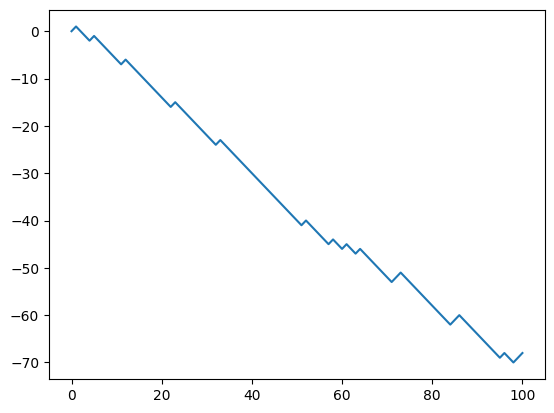

In [3]:
true_p = torch.logit(torch.tensor(0.25))
true_data = rw.observe(rw.run(torch.tensor([true_p])))

plt.plot(true_data[0].numpy())

## Defining the calibrator

In [4]:
?Calibrator

Init signature:
Calibrator(
    model: blackbirds.models.model.Model,
    prior: torch.distributions.distribution.Distribution,
    posterior_estimator: torch.nn.modules.module.Module,
    data: List[torch.Tensor],
    w: float = 0.0,
    initialize_flow_to_prior: bool = False,
    initialization_lr: float = 0.001,
    gradient_clipping_norm: float = inf,
    forecast_loss: Optional[Callable] = None,
    optimizer: torch.optim.optimizer.Optimizer | None = None,
    n_samples_per_epoch: int = 10,
    n_samples_regularisation: int = 10000,
    diff_mode: str = 'reverse',
    gradient_estimation_method: str = 'pathwise',
    jacobian_chunk_size: int | None = None,
    gradient_horizon: int = 0,
    device: str = 'cpu',
    progress_bar: bool = True,
    progress_info: bool = True,
    log_tensorboard: bool = False,
    tensorboard_log_dir: str | None = None,
)
Docstring:     
Class that handles the training of the posterior_estimator given the model, data, and prior.

**Arguments:**

- `m

In [5]:
posterior_estimator = TrainableGaussian([0.], 1.0)
prior = torch.distributions.Normal(true_p + 0.2, 1)
optimizer = torch.optim.Adam(posterior_estimator.parameters(), 1e-2)

calibrator = Calibrator(model = rw, posterior_estimator=posterior_estimator, prior=prior, data=true_data, optimizer=optimizer, w = 0)

In [6]:
# we can now train the estimator for a 100 epochs
calibrator.run(1000, max_epochs_without_improvement=100)

 65%|████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████▌                                                                      | 646/1000 [01:48<00:59,  5.97it/s, Forecast=20.3, Reg.=0, total=20.3, best loss=12.2, epochs since improv.=100]


The model stops when it hits a certain amount of epochs without improvement.
The run function returns the loss per epoch as well as the best model weights.
Let's have a look at the loss first:

In [7]:
df = pd.DataFrame(calibrator.losses_hist)
df.head()

,total,forecast,regularisation
0,2888.479248,2888.479248,0.0
1,1226.308960,1226.308960,0.0
2,2405.631592,2405.631592,0.0
3,2236.514893,2236.514893,0.0
4,2558.677246,2558.677246,0.0


<Axes: >

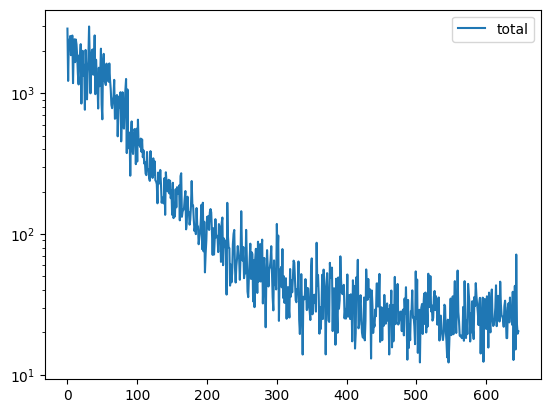

In [8]:
df.plot(y="total", logy=True)

In [9]:
# We can now load the best model
posterior_estimator.load_state_dict(calibrator.best_model_state_dict)

<All keys matched successfully>

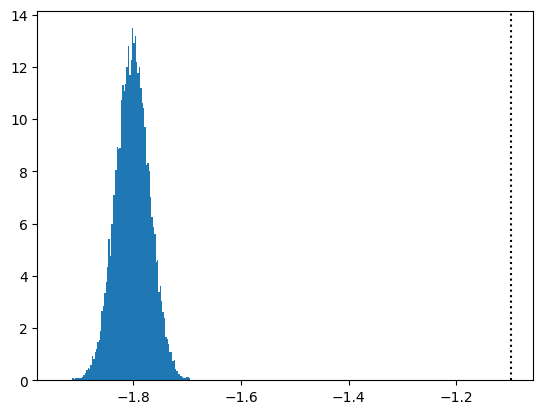

In [10]:
# and plot the posterior
with torch.no_grad():
    samples = posterior_estimator.sample(20000)[0].flatten().cpu()
plt.hist(samples, density=True, bins=100);
plt.axvline(true_p, label = "true value", color = "black", linestyle=":")

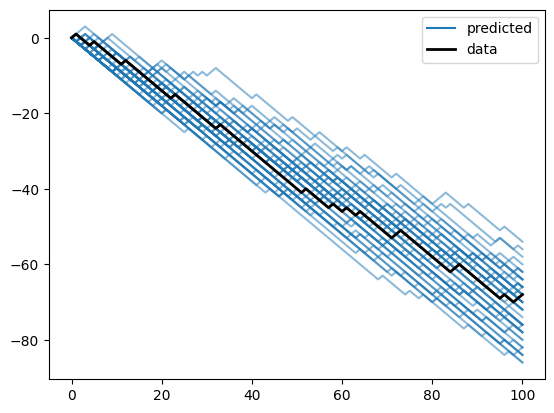

In [11]:
# compare the predictions to the synthetic data:

f, ax = plt.subplots()

for i in range(50):
    with torch.no_grad():
        sim_rw = rw.observe(rw.run(posterior_estimator.sample(1)[0]))[0].numpy()
    ax.plot(sim_rw, color = "C0", alpha=0.5)
    
ax.plot([], [], color = "C0", label = "predicted")
ax.plot(true_data[0], color = "black", linewidth=2, label = "data")

ax.legend()